### Capstone project: Spotify_Data_Exploration

**Data  source:  https://www.kaggle.com/datasets/sveta151/spotify-top-chart-songs-2022 
​​This dataset provides a list of all songs that have appeared in a weekly Spotify top chart.
Dataset provides name of the song, artist, URI, peak rank in the top charts that this song got, number of weeks on chart and main features of the song such as danceability, energy etc


**BusinessQuestion that I intend to answer:
Predict songs ranks or if the song will be in the top 20 on the apple music



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install feature-engine
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time

set_config(display="diagram")

###Load The Data
I have downloaded the data to a local drive 

In [18]:
import os


file_path = '/Users/personal/Downloads/Capstone_project/data/song_data.CSV'
 
# Check if we have read permission for the file
if os.access(file_path, os.R_OK):
    print("You have read permission for the file.")
else:
    print("You do not have read permission for the file.")

song =pd.read_csv(file_path, encoding = 'latin-1')

You have read permission for the file.


In [19]:
### Take a quick look of the data
song = song.rename(columns={'artist(s)_name': 'artist_name'})
song.head()

,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


[Back to top](#-Index)

### Deeper look of the data 

In [20]:
# Always Save the original file
data =song.copy()
print(data.columns)
print(data.isna().sum())
print(data.info())
print(data.describe())

Index(['track_name', 'artist_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')
track_name               0
artist_name              0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
aco

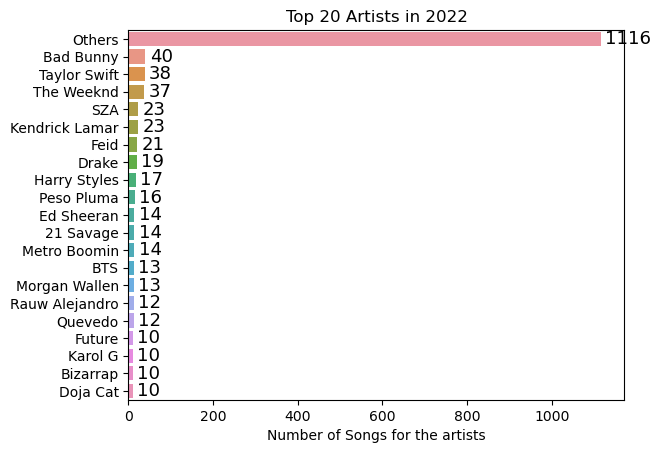

In [21]:
# take a look at the data

artists_names = data.artist_name.str.split(',')
all_artist = artists_names.explode().str.strip()
encoder = RareLabelEncoder(max_n_categories=20, tol=0.001, replace_with='Others')
data_to_plot = encoder.fit_transform(all_artist.to_frame(name='artist')).artist.value_counts()

ax = sns.barplot(
    y=data_to_plot.index,
    x=data_to_plot,
    orient='h',
    
);

ax.set_title('Top 20 Artists in 2022')
ax.set_xlabel('Number of Songs for the artists');
ax.bar_label(ax.containers[0], padding=3, fontsize=13);

In [22]:
numerical_columns = song.select_dtypes(include=['int', 'float']).columns.tolist()

print("Numerical columns:", numerical_columns)

Numerical columns: ['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


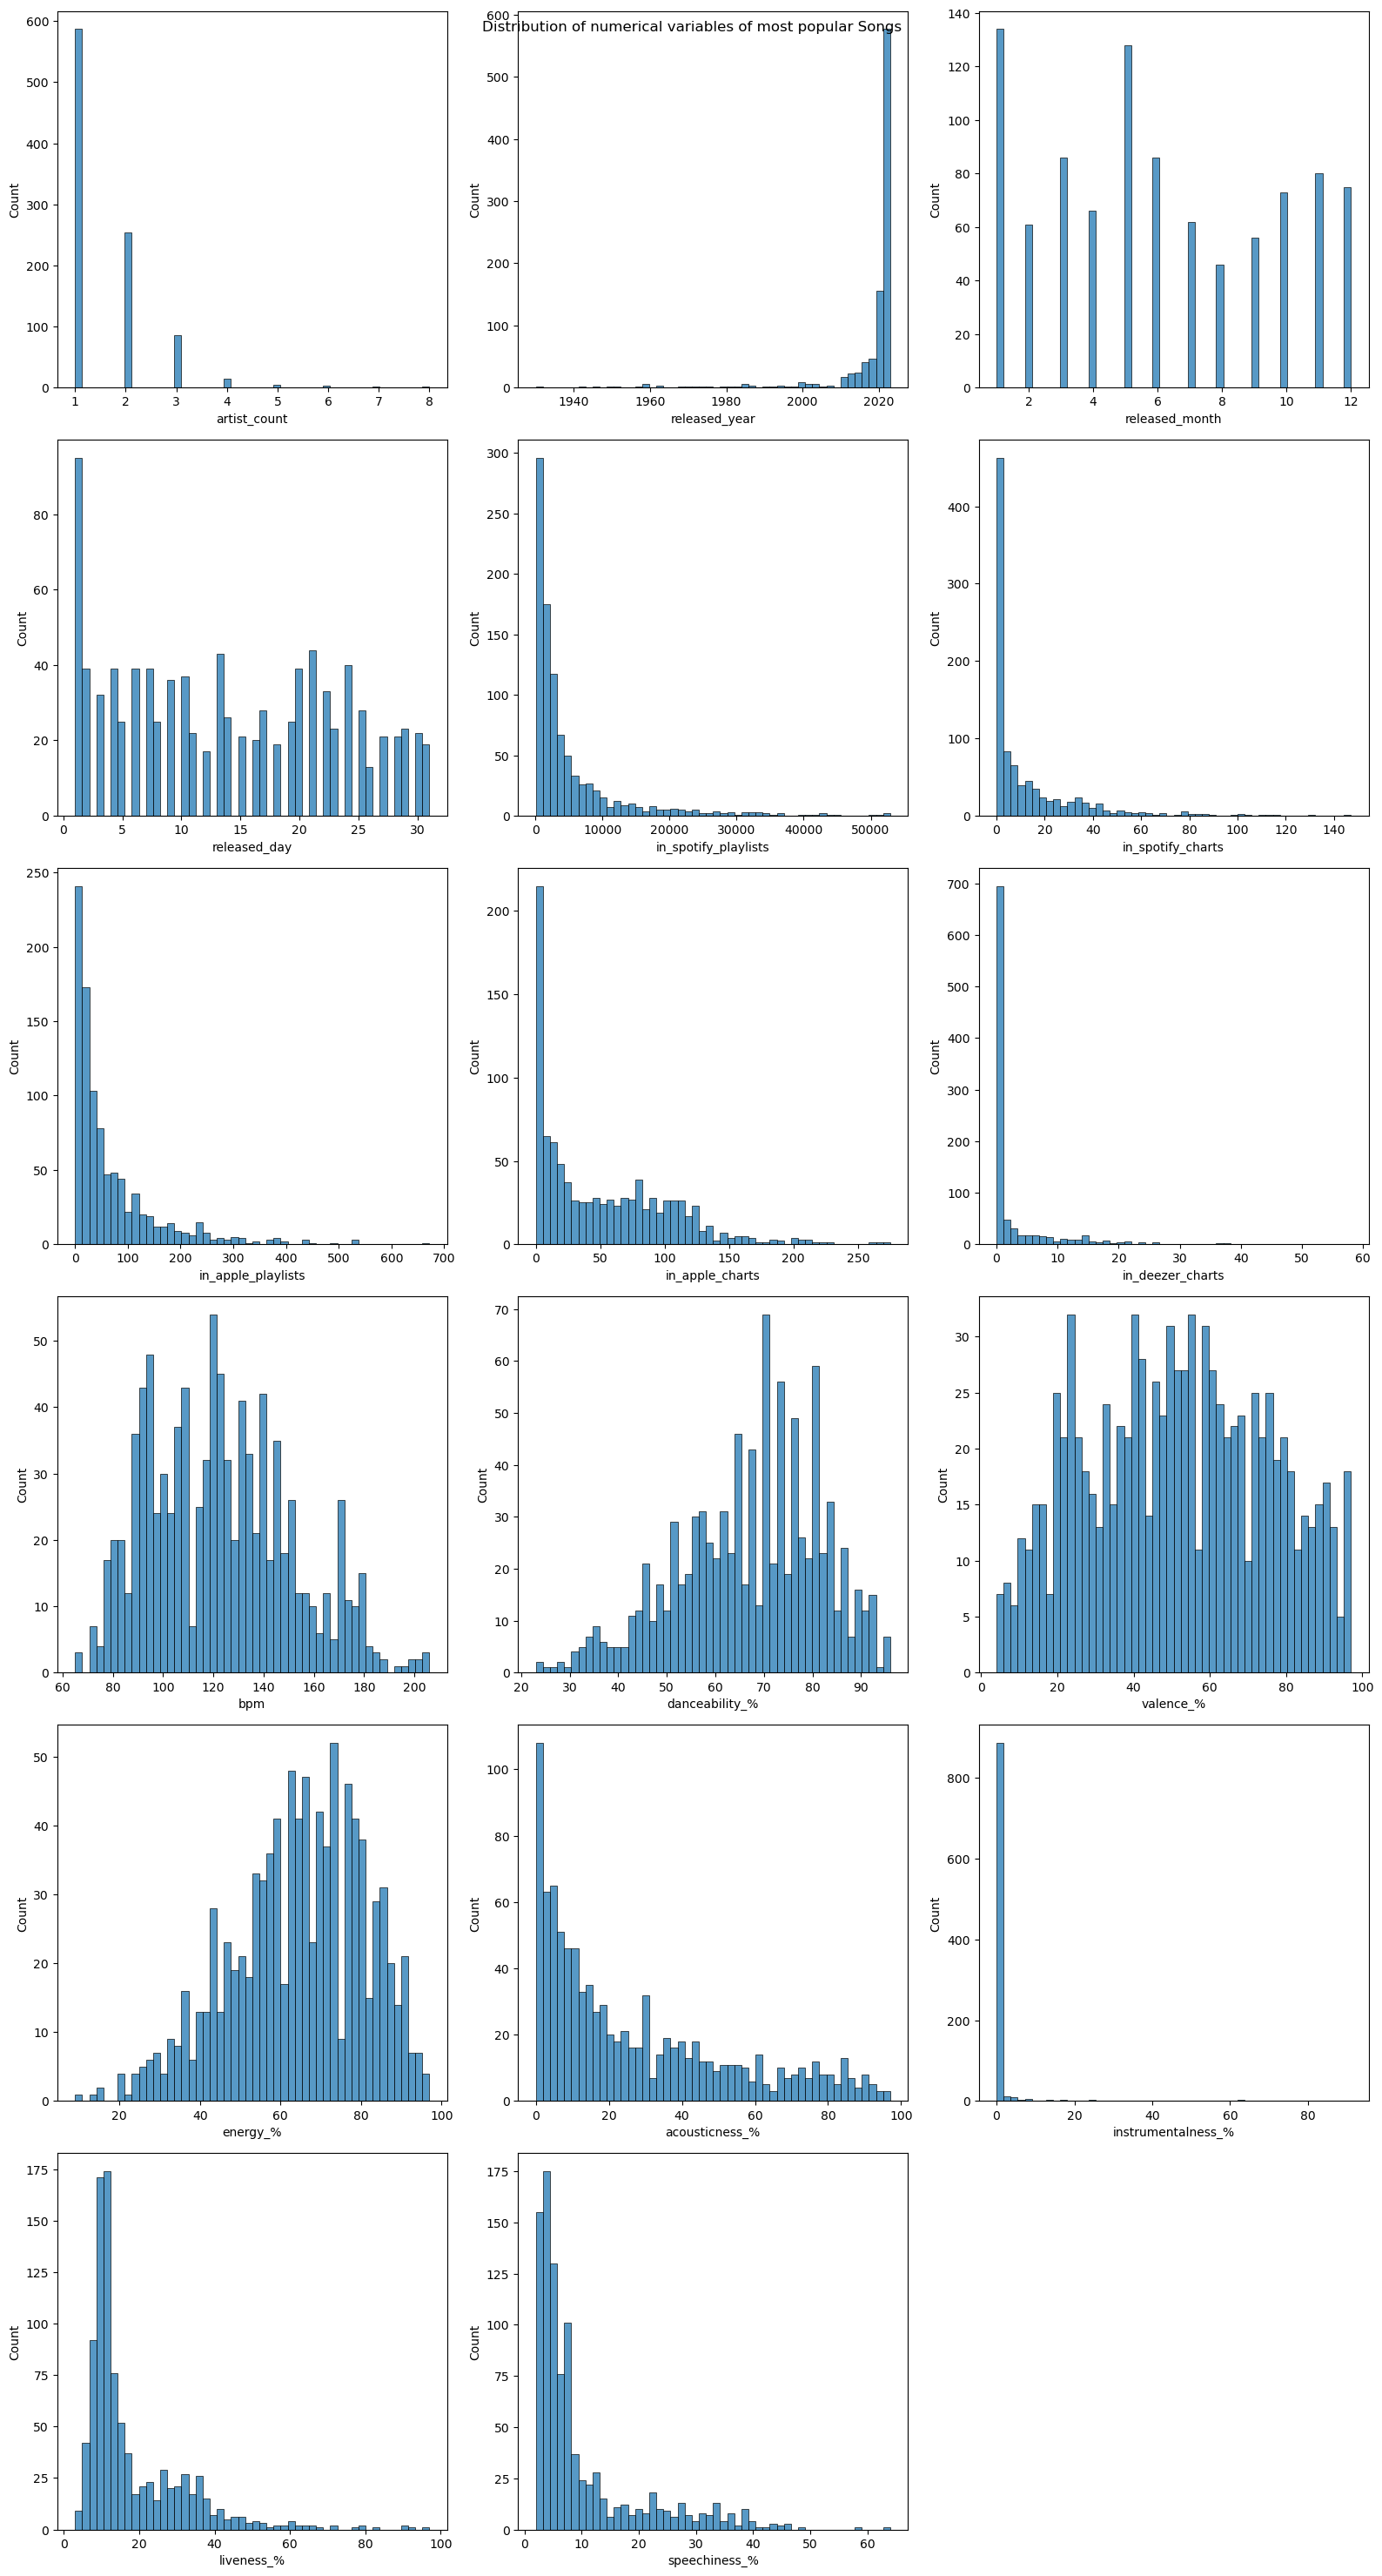

In [23]:
import math
import matplotlib.ticker as ticker
no_rows = math.ceil(len(numerical_columns)/3)
fig, ax = plt.subplots(math.ceil(len(numerical_columns)/3), 3, figsize=(16, no_rows*5))
ax = ax.flatten()
axs = {}

for i, column in enumerate(numerical_columns):
    sns.histplot(song[column], ax=ax[i], bins=50)
    axs[column] = ax[i]
    
#axs['duration_m'].xaxis.set_major_locator(ticker.MaxNLocator(11))
ax[-1].set_axis_off()
fig.suptitle('Distribution of numerical variables of most popular Songs');
plt.tight_layout()


[Back to top](#-Index)

###  Data Cleaning and Data encoding
  We have a few object columns that we need to convert to numerical columns: 
  out of the 23 columns, there are 7 Object columns.
  we will use labelEncoder 
  
  Data columns (total 24 columns):
  
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    object
 16  mode                  953 non-null    object
 17  danceability_%        953 non-null    int64 
 18  valence_%             953 non-null    int64 
 19  energy_%              953 non-null    int64 
 20  acousticness_%        953 non-null    int64 
 21  instrumentalness_%    953 non-null    int64 
 22  liveness_%            953 non-null    int64 
 23  speechiness_%         953 non-null    int64 

In [24]:
Encoder=LabelEncoder()

for i in data.select_dtypes(include='object').columns.values:
    data[i]=Encoder.fit_transform(data[i])
    print(data[i].isna().sum())

print(data.isna().sum())

0
0
0
0
0
0
0
track_name              0
artist_name             0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [25]:
data.head()


,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,687,326,2,2023,7,14,553,147,156,43,...,125,2,0,80,89,83,31,0,8,4
1,397,401,1,2023,3,23,1474,48,125,48,...,92,3,0,71,61,74,7,0,10,4
2,936,431,1,2023,6,30,1397,113,151,94,...,138,7,0,51,32,53,17,0,31,6
3,170,558,1,2019,8,23,7858,100,864,116,...,170,0,0,55,58,72,11,0,11,15
4,864,43,1,2023,5,18,3133,50,499,84,...,144,0,1,65,23,80,14,63,11,6


<Axes: >

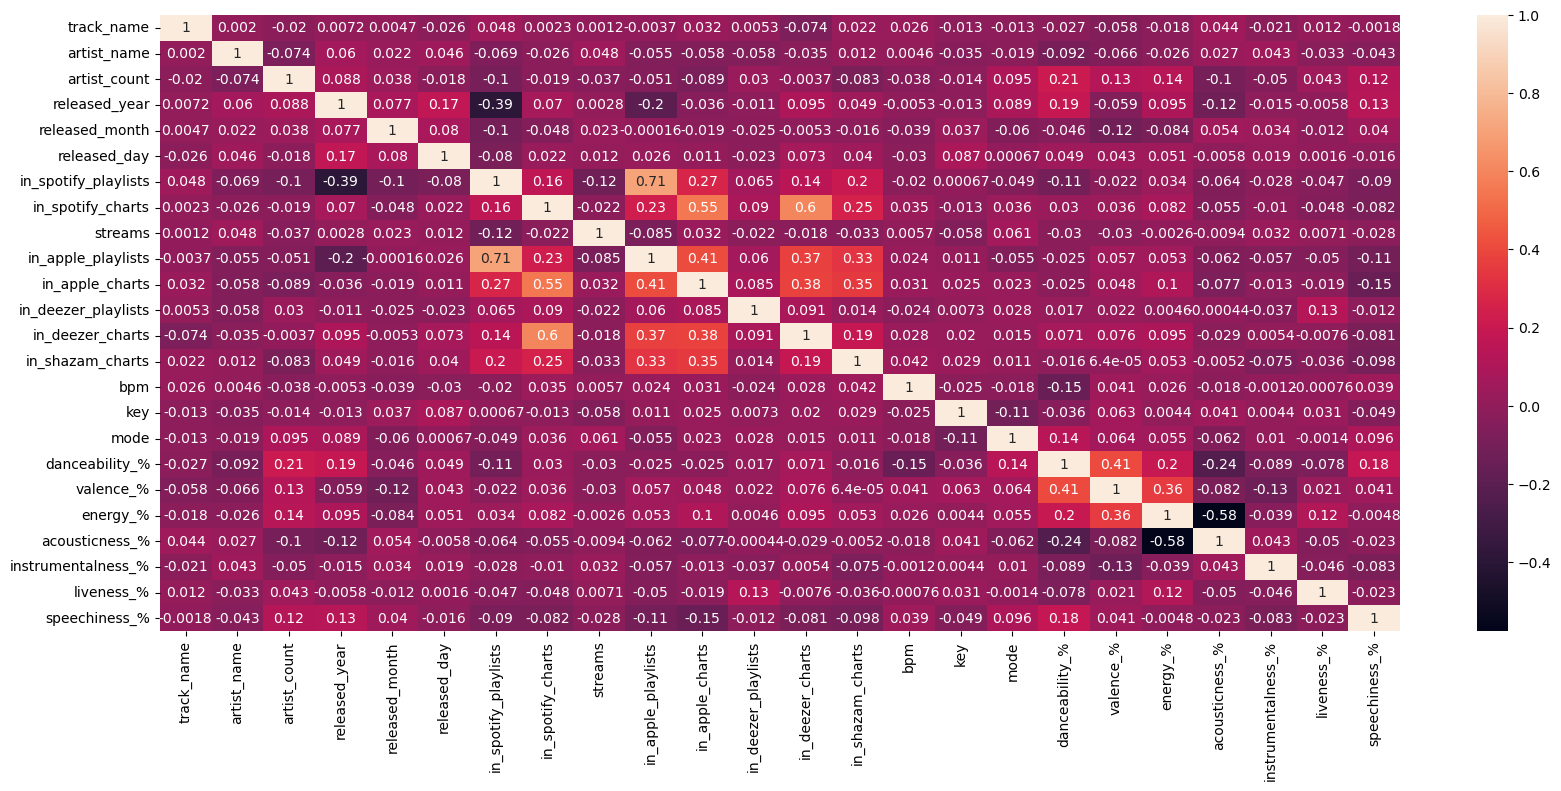

In [26]:
plt.figure(figsize=(20,8))
sns.heatmap(data.corr(),annot=True)

<Axes: xlabel='danceability_%', ylabel='energy_%'>

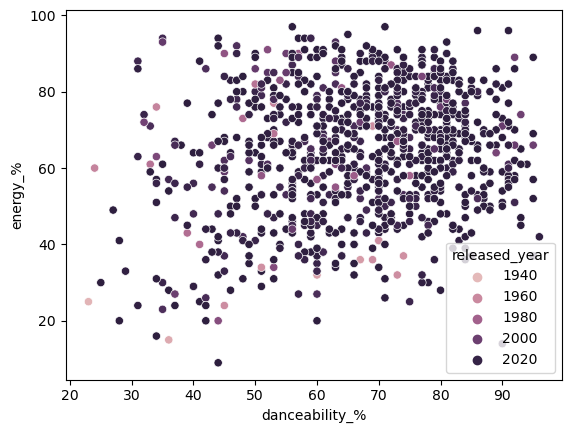

In [27]:
# checking to see if the energy, dancebility and released years have any trend,  we did not see any from the plot
sns.scatterplot(data=data,x= "danceability_%",y="energy_%",hue="released_year")

<Axes: xlabel='released_year', ylabel='energy_%'>

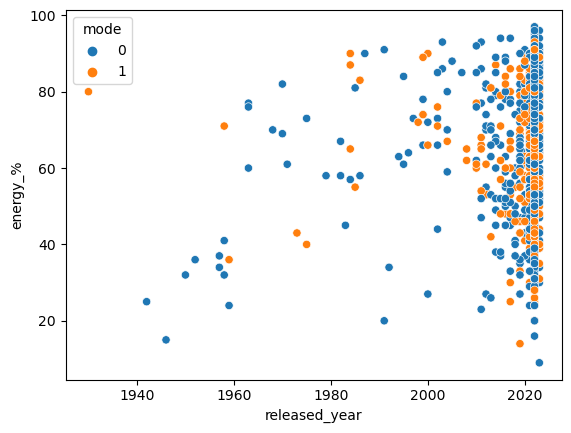

In [28]:
#checking to see mode and energy have any trend over the years
sns.scatterplot(data=data,x= "released_year",y="energy_%",hue="mode")

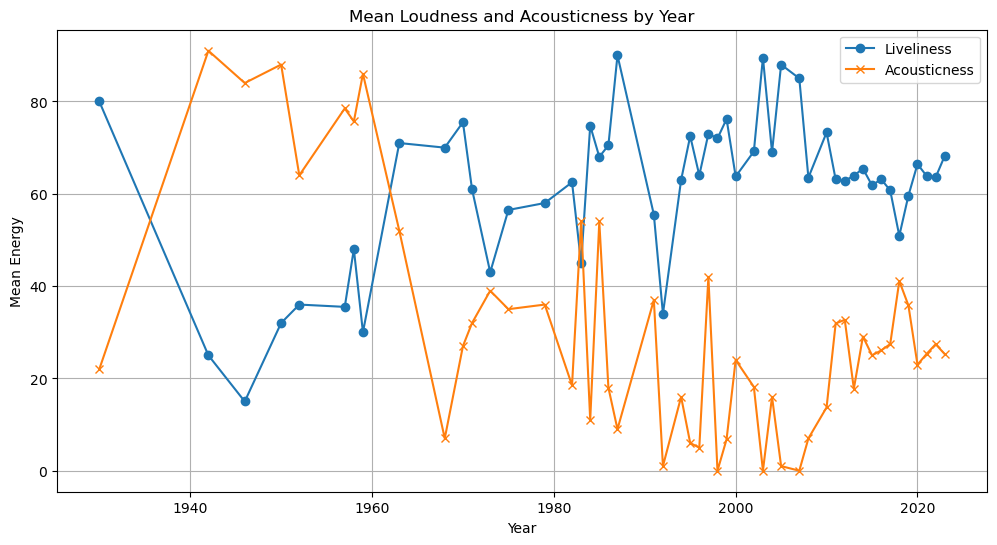

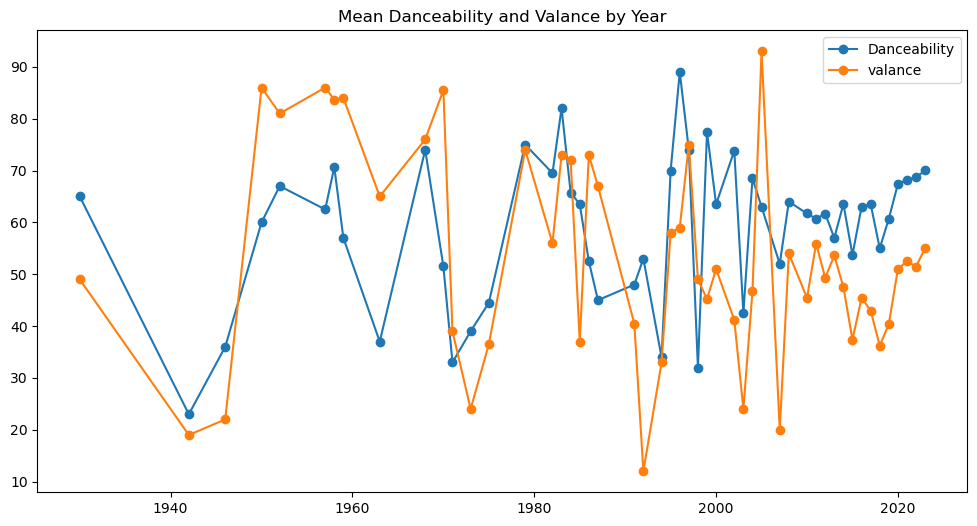

In [29]:
#curious if the loudness increase or acousticness changes over the years
loudness_by_year = data.groupby('released_year')['energy_%'].mean()
dance_by_year = data.groupby('released_year')['danceability_%'].mean()
valance_by_year = data.groupby('released_year')['valence_%'].mean()
acoustic_by_year = data.groupby('released_year')['acousticness_%'].mean()
# Create a line plot of the mean loudness by year
plt.figure(figsize=(12, 6))

#plt.plot(dance_by_year.index, loudness_by_year.values, marker='x', linestyle='--')
plt.plot(loudness_by_year.index, loudness_by_year.values, label ='Liveliness', marker='o', linestyle='-')
plt.plot(loudness_by_year.index, acoustic_by_year.values, label ='Acousticness', marker='x', linestyle='-')

plt.title('Mean Loudness and Acousticness by Year')
plt.xlabel('Year')
plt.ylabel('Mean Energy')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dance_by_year.index, dance_by_year.values, label ='Danceability', marker='o', linestyle='-')

plt.plot(valance_by_year.index, valance_by_year.values, label = 'valance' , marker='o', linestyle='-')
plt.title('Mean Danceability and Valance by Year')
plt.legend()
plt.show()

## Insight
 very intersting to see the loudness definitely have a pattern, the music alternate (every few years quiter to louder
### overall the mean of loudness is tending up ) 
### the acousticness is trending slight down.  
### the music is becoming slightly louder, less acoustic over the years


<Axes: >

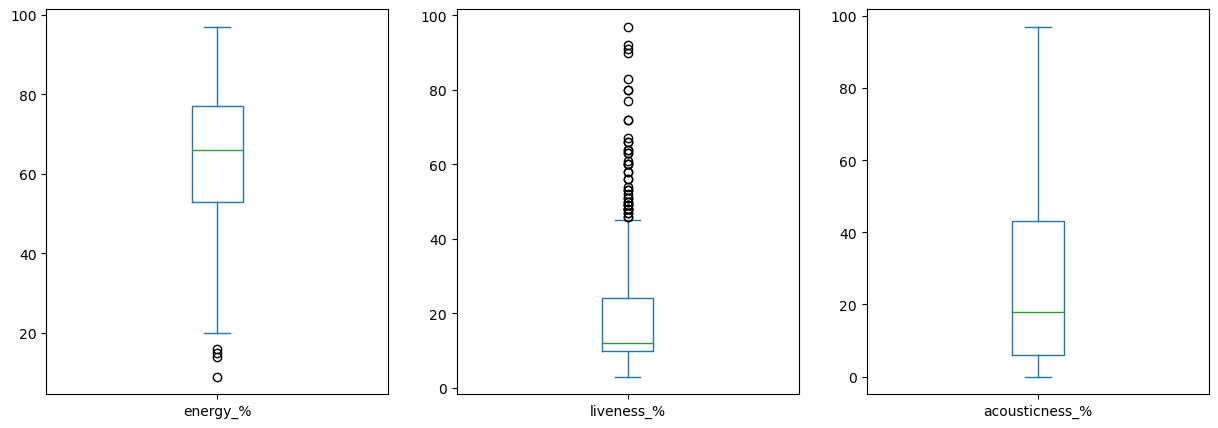

In [31]:
f, ax = plt.subplots(1,3,figsize=(15,5))

data["energy_%"].plot(kind="box",ax=ax[0])
data["liveness_%"].plot(kind="box",ax=ax[1])
data["acousticness_%"].plot(kind="box",ax=ax[2])

In [91]:
# first look at the features that are correlated to ranks
### will convert to a binary classification
# top_ten =1, for songs in top 20 or  top_ten =0 for others

data['Top20'] = 0

data.loc[(data['in_apple_playlists'] < 20), 'Top20'] = 1 


y_org=data['Top20']
X_org = data.drop(columns=['Top20', 'in_apple_playlists'])
## reduce datasize to 200, later to 500
num_samples_to_keep =500

random_indices = np.random.choice(len(X_org), size=num_samples_to_keep, replace=False)

X = X_org.iloc[random_indices]
y = y_org.iloc[random_indices]
#X=X_org
#y=y_org
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [34]:


knn_pipe = KNeighborsClassifier()

# Define the hyperparameters and their possible values
params = {'n_neighbors': [3, 5, 7, 10, 20]}

# Create a GridSearchCV object with the KNN classifier and parameter grid
grid = GridSearchCV(estimator=knn_pipe, param_grid=params, cv=5)  # You can specify the number of cross-validation folds (cv)

# Fit the GridSearchCV object to your training data
grid.fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_n= grid.best_params_['n_neighbors']

#Now use the best KNN parameter to  find trainig time
knn_pipe = KNeighborsClassifier(n_neighbors =best_n)

start_time = time.time()
knn_pipe.fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
knn_training_time = end_time - start_time

In [35]:
knn_score_test= accuracy_score(knn_pipe.predict(X_test), y_test)
knn_score_train= accuracy_score(knn_pipe.predict(X_train), y_train)
print('knn_score_train is ', knn_score_train )
print('knn_score_test is ', knn_score_test)
print ('Best_n', best_n)
test_predictions = knn_pipe.predict_proba(X_test)
print('knn_training_time ', knn_training_time)
### save results 
# Best_n 7
# knn_training_time  0.0004830360412597656

knn_score_train is  0.848
knn_score_test is  0.84
Best_n 7
knn_training_time  0.001417398452758789



[Back to top](#-Index)

###  KNN results

#for 200
#knn_score_train is  0.9133333333333333
#knn_score_test is  0.74
#Best_n 3
#knn_training_time  0.0014634132385253906


### for 500
- knn_score_train is  0.848
- knn_score_test is  0.84
- Best_n 7
- knn_training_time  0.001417398452758789


In [45]:
### Logistic Regresssion
# Gridsearch to find the optimal paramenters for logistic Regression
lgr =LogisticRegression()
params = {'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',],
         'C': [0.1, 1.0, 10.0, 100.0],}

grid = GridSearchCV(lgr, param_grid=params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_solver = grid.best_params_['solver']
best_C = grid.best_params_['C']
print(grid_score)
print(best_solver, best_C)

### Save results

/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packag

0.792
sag 0.1


/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/personal/anaconda3/lib/python3.10/site-packag

In [46]:
print(grid_score)
print(best_solver, best_C)

0.792
sag 0.1


In [47]:

start_time = time.time()
lgr_best = LogisticRegression(solver =best_solver, C = best_C ).fit(X_train, y_train)
end_time = time.time()
lgr_score_test= accuracy_score(lgr_best.predict(X_test), y_test)
lgr_score_train= accuracy_score(lgr_best.predict(X_train), y_train)
print('lgr_score_train is ', lgr_score_train )
print('lgr_score_test is ', lgr_score_test)
# Calculate the training time with default parameters
lgr_training_time = end_time - start_time
print('Logistic Regreassion _training_time ', lgr_training_time)


lgr_score_train is  0.8266666666666667
lgr_score_test is  0.792
Logistic Regreassion _training_time  0.021414995193481445


/Users/personal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Back to top](#-Index)

###  Logistic Regression Results 

lgr_score_train is  0.8266666666666667
lgr_score_test is  0.792
Logistic Regreassion _training_time  0.021414995193481445

[Back to top](#-Index)

###  Test various SVC

my computer hangs with the gridsearch if I do all together, so I split into several

In [ ]:
####. my computer hangs with the gridsearch if I do all together, so I split into several

#params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
#         'gamma': [0.1, 1.0, 10.0, 100.0],}
#start_time = time.time()
#svc = SVC().fit(X_train, y_train)
# Gridsearch to find the optimal paramenters 

#params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
#         'gamma': [0.1, 1.0, 10.0, 100.0],}
#grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
#grid_score = grid.score(X_test, y_test)
#best_kernel = grid.best_params_['kernel']
#best_gamma =grid.best_params_['gamma']
#print(grid_score)
#print(best_kernel)#end_time = time.time()



# Calculate the training time
#SVC_training_time = end_time - start_time
#svc_score= accuracy_score(svc.predict(X_test), y_test)
print('SV_training_time ',  SVC_training_time) 
print('svc_score is ', svc_score )
#SV_training_time  0.005994081497192383
#svc_score is  0.84

In [38]:
svc = SVC()
params = {'kernel': ['rbf'],
         'gamma': [0.1, 1.0, 10.0, 100.0],}
grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['kernel']
best_gamma =grid.best_params_['gamma']
print(grid_score)
print(best_kernel)

0.616
rbf


In [39]:
svc = SVC()
params = {'kernel': ['poly'],
         'gamma': [0.1, 1.0, 10.0, 100.0],}
grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['kernel']
best_gamma =grid.best_params_['gamma']
print(grid_score)
print(best_kernel)
print(best_gamma)

0.784
poly
0.1


In [40]:
#Now use the best parameters and find the training time
start_time = time.time()
svc = SVC(kernel= 'poly', gamma=0.1).fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
SVC_training_time = end_time - start_time
svc_score_test= accuracy_score(svc.predict(X_test), y_test)
svc_score_train= accuracy_score(svc.predict(X_test), y_test)
print('SV_training_time ',  SVC_training_time) 
print('svc_score_train is ', svc_score_train )
print('svc_score_test is ', svc_score_test )

SV_training_time  2.8977248668670654
svc_score_train is  0.784
svc_score_test is  0.784


In [92]:
svc = SVC()
params = {'kernel': [ 'linear'],
         'gamma': [0.1, 1.0, 10.0, 100.0],}
grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['kernel']
best_gamma =grid.best_params_['gamma']
print(grid_score)
print(best_kernel)

0.848
linear


In [93]:
print(grid_score)
print(best_gamma)
print(best_kernel)

0.848
0.1
linear


In [94]:
start_time = time.time()
svc = SVC(kernel= 'linear', gamma=0.1).fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
SVC_training_time = end_time - start_time
svc_score_test= accuracy_score(svc.predict(X_test), y_test)
svc_score_train= accuracy_score(svc.predict(X_test), y_test)
print('SV_training_time ',  SVC_training_time) 
print('svc_score_train is ', svc_score_train )
print('svc_score_test is ', svc_score_test )
#save results 
#SV_training_time  68.99942111968994
#svc_score_train is  0.848
#svc_score_test is  0.848

SV_training_time  68.99942111968994
svc_score_train is  0.848
svc_score_test is  0.848


In [42]:
# for sigmoid best score is 0.616 and it is a not a good candidate

svc = SVC()

params = {'kernel': [ 'sigmoid'],
         'gamma': [0.1, 1.0, 10.0, 100.0],}
grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['kernel']
best_gamma =grid.best_params_['gamma']
print(grid_score)
print(best_kernel)

0.616
sigmoid


In [ ]:
# Gridsearch to find the optimal paramenters 

#params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
#         'gamma': [0.1, 1.0, 10.0, 100.0],}
#grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
#grid_score = grid.score(X_test, y_test)
#best_kernel = grid.best_params_['kernel']
#best_gamma =grid.best_params_['gamma']
#print(grid_score)
#print(best_kernel)

#start_time = time.time()
#svc = SVC('kernel'=best_kernel, 'gamma' = best_gamma  ).fit(X_train, y_train)
#end_time = time.time()

# Calculate the training time
#SVC_training_time = end_time - start_time

[Back to top](#-Index)

### Final evaluation of the top algo: KNN

#### Precision for different thresholds



In [50]:

def precision_thresh(predict_probs, 
                  y_test, 
                  thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent precision score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for precision value
    """
    return None

def precision_thresh(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    
    return precision_score(y_test, preds, pos_label=1)

# check the function
print(precision_thresh(test_predictions[:, 1], y_test, 0.1))
print(precision_thresh(test_predictions[:, 1], y_test, 0.9))

0.5476190476190477
0.9


[Back to top](#-Index)

### Determining precision for multiple thresholds



In [51]:
thresholds = np.arange(0, 1, .1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [52]:


results_df = ''

results_df = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]})

results_df

,threshold,precision
0,0.0,0.384000
1,0.1,0.547619
2,0.2,0.661538
3,0.3,0.696429
4,0.4,0.696429
5,0.5,0.833333
6,0.6,0.882353
7,0.7,0.882353
8,0.8,0.892857
9,0.9,0.900000


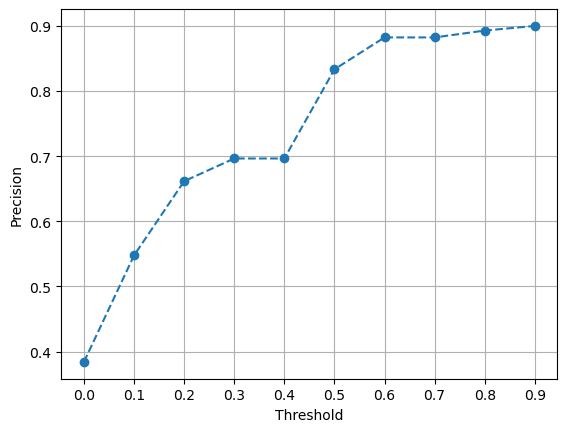

In [54]:
## visualize precision changes
precision_df=results_df.copy()
plt.plot(precision_df['threshold'], precision_df['precision'], '--o', label = 'precision')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid();

[Back to top](#-Index)

###  A Recall threshold function

 compute the recall given a threshold.   

In [56]:
### GRADED
def recall_thresh(predict_probs, 
                  y_test, 
                  thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent recall score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for recall value
    """
    return None

def recall_thresh(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 1, 0)
    
    return recall_score(y_test, preds, pos_label=1)
results_df['recall'] = [recall_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]


print(recall_thresh(test_predictions[:, 1], y_test, 0.1))
print(recall_thresh(test_predictions[:, 1], y_test, 0.9))
results_df

0.9583333333333334
0.1875


,threshold,precision,recall
0,0.0,0.384000,1.000000
1,0.1,0.547619,0.958333
2,0.2,0.661538,0.895833
3,0.3,0.696429,0.812500
4,0.4,0.696429,0.812500
5,0.5,0.833333,0.729167
6,0.6,0.882353,0.625000
7,0.7,0.882353,0.625000
8,0.8,0.892857,0.520833
9,0.9,0.900000,0.187500


[Back to top](#-Index)

###  Precision vs. Recall Tradeoff

check the trade off of the precision and recall.  



[0.         0.14285714 0.28571429 0.42857143 0.57142857]


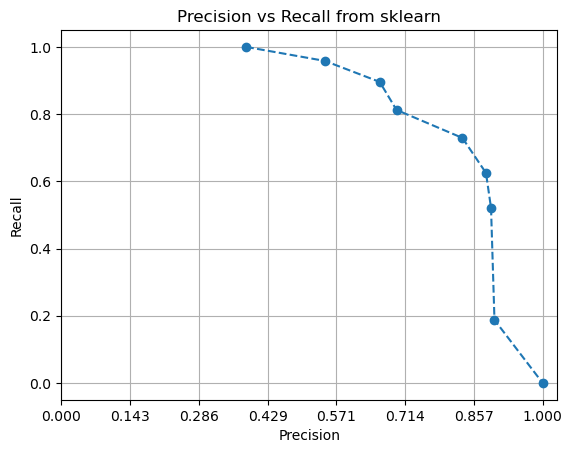

In [57]:

precision, recall, boundaries = '', '', ''


precision, recall, boundaries = precision_recall_curve(y_test, test_predictions[:, 1], pos_label=1)

print(boundaries[:5])
plt.plot(precision, recall, '--o')
plt.xticks(boundaries);
plt.grid()
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall from sklearn');

[Back to top](#-Index)

###  ROC Curve

plot the false positive rates, true positive rates, and thresholds.  

False Positive Rates:  [0.         0.01298701 0.03896104 0.05194805 0.09090909]
True Positive Rates:  [0.         0.1875     0.52083333 0.625      0.72916667]


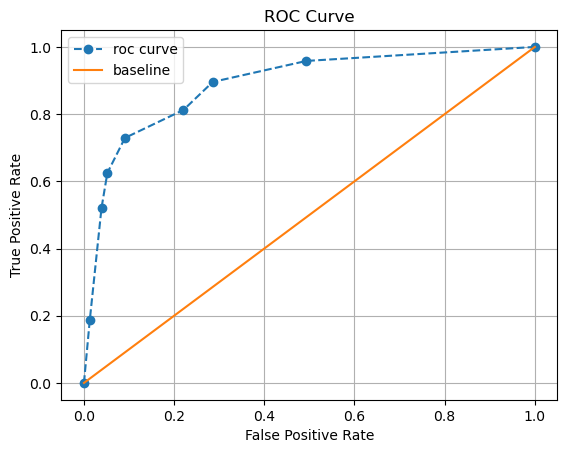

In [59]:
### GRADED
fpr, tpr, thresh_rocs = '', '', ''

### BEGIN SOLUTION
fpr, tpr, thresh_rocs = roc_curve(y_test, test_predictions[:, 1], pos_label=1)
### END SOLUTION

# Answer check
print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

[Back to top](#-Index)



#### Area Under Curve as metric
use the proposed area under the curve scoring method.  Below, construct a grid search named `roc_grid` that uses the `knn_pipe` and searches over the number of neighbors from 1 to 31 by odd values, choosing the model that optimizes `roc_auc_score`.  Identify the optimal number of neighbors and assign to `best_k` and we will compare with the Gridsearch results earlier

In [61]:

roc_grid = ''
best_k = ''


roc_grid = GridSearchCV(knn_pipe, param_grid={'n_neighbors': range(1, 33, 2)}, scoring = 'roc_auc')
roc_grid.fit(X_train, y_train)
best_k = roc_grid.best_params_['n_neighbors']

best_k

19

## it is very intersting.  N=7 use the Gridsearch results while Roc_grid gave n=19,
### however, we can see from the curve they are quite close

#### Visualizing with scikitlearn

Below, we use the `RocCurveDisplay` to display roc curves for three knn models.  You can either use predictions or estimators to create the visualization.  Below, we use the `from_estimator` method.

In [63]:
from sklearn.metrics import RocCurveDisplay

In [64]:
knn_1 = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 1))])
knn_1.fit(X_train, y_train)

Pipeline(steps=[('transform', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

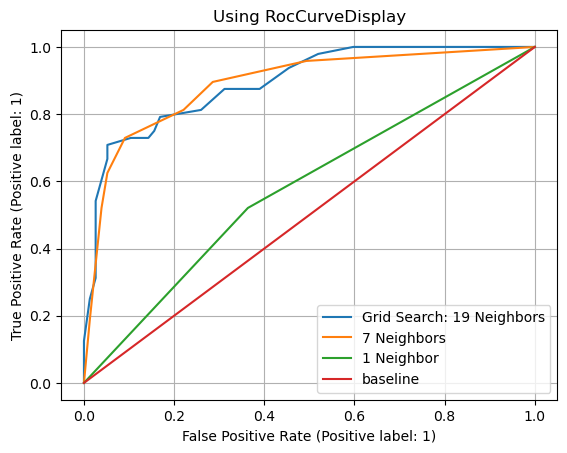

In [65]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(roc_grid, X_test, y_test, pos_label = 1, ax = ax, label = 'Grid Search: 19 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, pos_label = 1, ax = ax, label = '7 Neighbors')
RocCurveDisplay.from_estimator(knn_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

In [75]:
dtree = ''
path = ''

### BEGIN SOLUTION
dtree = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
path = dtree.cost_complexity_pruning_path(X_train, y_train)
train_accs = []
test_accs = []
ccp_alphas = path.ccp_alphas
impurities = path.impurities

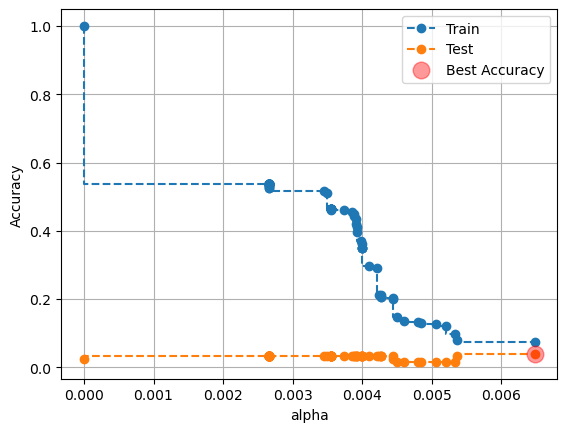

In [76]:

for i in ccp_alphas[:-1]:
    pass


### BEGIN SOLUTION
train_accs = []
test_accs = []
for i in ccp_alphas[:-1]:
    dtree = DecisionTreeClassifier(random_state=42, ccp_alpha=i).fit(X_train, y_train)
    train_accs.append(dtree.score(X_train, y_train))
    test_accs.append(dtree.score(X_test, y_test))
### END SOLUTION

# # Answer check
plt.step(ccp_alphas[:-2], train_accs[:-1], '--o', label = 'Train')
plt.step(ccp_alphas[:-2], test_accs[:-1], '--o', label = 'Test')
plt.plot(ccp_alphas[np.argmax(test_accs)], max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Accuracy')
plt.legend()
plt.grid()
plt.xlabel('alpha')
plt.ylabel('Accuracy');

In [ ]:
### Decision tree does not work well for this test data 


# Part 2 predict song ranks 
### We will reset the data and try to predict the song's rank using Lasso and sequential feature selection
### as we will see the the MSE with testing dataset are similar with both Lasso and sequential, even though the training error for Lasso is much smaller 

With the random 500 sample
Lasso: 
print(lasso_train_mse)
print(lasso_test_mse)
733.3083531677235
2848.2485754424715

Sequntial 
print(sequential_train_mse)
print(sequential_test_mse)
1915.6558261761124
2796.2627106386744


with the full data set, predict song ranks
Lasso: 
print(lasso_train_mse)
print(lasso_test_mse)

1163.0087944113584
1575.8814003712062

print(sequential_train_mse)
print(sequential_test_mse)

1980.5242989189271
2424.810751857526



In [67]:

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error

In [83]:


y_org_1=data['in_apple_playlists']   # change target to the actual rank
#X_org = data.drop(columns=['Top20', 'in_apple_playlists']),  No change for X
## reduce datasize to 200, later to 500
num_samples_to_keep =500

#random_indices = np.random.choice(len(X_org), size=num_samples_to_keep, replace=False)

#X = X_org.iloc[random_indices]
#y = y_org_1.iloc[random_indices]

#--------


#experiment 2:    truely try to predict the ranks for the full data set
X=X_org
y=y_org_1
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(X,y)

In [84]:

auto_pipe = ''
lasso_coefs = ''

### BEGIN 
auto_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler()),
                     ('lasso', Lasso(random_state = 42))])
auto_pipe.fit(auto_X_train, auto_y_train)
lasso_coefs = auto_pipe.named_steps['lasso'].coef_
lasso_train_mse = mean_squared_error(auto_y_train, auto_pipe.predict(auto_X_train))
lasso_test_mse = mean_squared_error(auto_y_test, auto_pipe.predict(auto_X_test))
print(lasso_train_mse)
print(lasso_test_mse)

1163.0087944113584
1575.8814003712062


In [80]:

#Using the lasso_coefs determine the number of features with non-zero coefficients 
#and determine the name of those features as a result of the polynomial feature transformation
feature_names = ''
lasso_df = ''

feature_names = auto_pipe.named_steps['polyfeatures'].get_feature_names_out()
lasso_df = pd.DataFrame({'feature': feature_names, 'coef': lasso_coefs})

print(type(feature_names))
lasso_df.loc[lasso_df['coef'] != 0]

<class 'numpy.ndarray'>


,feature,coef


In [85]:
#Comparing Lasso to SequentialFeatureSelection¶
sequential_pipe = ''
sequential_train_mse = ''
sequential_test_mse = ''


### BEGIN SOLUTION
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                           ('selector', SequentialFeatureSelector(LinearRegression(), 
                                                                  n_features_to_select=6)),
                           ('linreg', LinearRegression())])
sequential_pipe.fit(auto_X_train, auto_y_train)
sequential_train_mse = mean_squared_error(auto_y_train, sequential_pipe.predict(auto_X_train))
sequential_test_mse = mean_squared_error(auto_y_test, sequential_pipe.predict(auto_X_test))
### END SOLUTION

# Answer check
print(sequential_train_mse)
print(sequential_test_mse)
sequential_pipe

1980.5242989189271
2424.810751857526


Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=6)),
                ('linreg', LinearRegression())])

##  Part 3 Hybrid approaching 
###  use Lasso and Sequential to predict if the song is on the top 20
### set target y =0, 1 if on the top 20
Then I decide to use the full data set, but use y at top 20 as a target,,
X=X_org
y=y_org


print(lasso_train_mse)
print(lasso_test_mse)
0.22360512832584012
0.22541213548344924

another run
0.2222222222222223
0.22966062296606235

print(sequential_train_mse)
print(sequential_test_mse)
0.14994851996261793
0.1413463544623823

another run
0.14535023376759143
0.1540730342275059

In [88]:
#experiment:  use full dataset, but try to predict only if they are top 20 or not, and we are very precise

#y_org=data['Top20']
# X_org = data.drop(columns=['Top20', 'in_apple_playlists'])   No change for X

X=X_org
y=y_org
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(X,y)

In [89]:

auto_pipe = ''
lasso_coefs = ''

### BEGIN 
auto_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler()),
                     ('lasso', Lasso(random_state = 42))])
auto_pipe.fit(auto_X_train, auto_y_train)
lasso_coefs = auto_pipe.named_steps['lasso'].coef_
lasso_train_mse = mean_squared_error(auto_y_train, auto_pipe.predict(auto_X_train))
lasso_test_mse = mean_squared_error(auto_y_test, auto_pipe.predict(auto_X_test))
print(lasso_train_mse)
print(lasso_test_mse)

0.2222222222222223
0.22966062296606235


In [90]:
#Comparing Lasso to SequentialFeatureSelection¶
sequential_pipe = ''
sequential_train_mse = ''
sequential_test_mse = ''


### BEGIN SOLUTION
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                           ('selector', SequentialFeatureSelector(LinearRegression(), 
                                                                  n_features_to_select=6)),
                           ('linreg', LinearRegression())])
sequential_pipe.fit(auto_X_train, auto_y_train)
sequential_train_mse = mean_squared_error(auto_y_train, sequential_pipe.predict(auto_X_train))
sequential_test_mse = mean_squared_error(auto_y_test, sequential_pipe.predict(auto_X_test))
### END SOLUTION

# Answer check
print(sequential_train_mse)
print(sequential_test_mse)
sequential_pipe

0.14535023376759143
0.1540730342275059


Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=6)),
                ('linreg', LinearRegression())])